In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append(os.path.realpath('..'))

In [3]:
import numpy as np
import scipy as sp
import pandas as pd
import plotly.express as ex
import plotly.graph_objects as go

from tracking_v2.util import to_df

# Tunable mover

In [176]:
import numpy as np

def normalize(v):
    """Normalize a vector."""
    norm = np.linalg.norm(v)
    return v / norm if norm > 0 else v

def compute_next_direction(P, V, A, B, theta_max, step_size, lookahead_factor=3.0):
    """
    Compute the next direction for the mover.
    
    Parameters:
    - P: Current position (3D numpy array)
    - V: Current direction (3D unit vector)
    - A: Point A defining the line (3D numpy array)
    - B: Target point B (3D numpy array)
    - theta_max: Maximum turn rate in radians
    - step_size: Distance moved per step
    - lookahead_factor: Multiplier for lookahead distance
    
    Returns:
    - V_next: Next direction (3D unit vector)
    """
    # Line direction from A to B
    AB = B - A
    L = normalize(AB)
    
    # Closest point C on line AB to position P
    AP = P - A
    t = np.dot(AP, L)
    C = A + t * L
    
    # Guidance point G ahead of C toward B
    lookahead_dist = step_size * lookahead_factor
    G = C + lookahead_dist * L
    
    # Desired direction toward G
    D = normalize(G - P)
    
    # Check angle between current direction V and desired direction D
    cos_theta = np.dot(V, D)
    cos_theta_max = np.cos(theta_max)
    
    if cos_theta >= cos_theta_max:
        # Desired direction is within turn limit
        V_next = D
    else:
        # Compute constrained direction by rotating V toward D by theta_max
        # Axis of rotation (perpendicular to V and plane of V-D)
        T = normalize(np.cross(V, D))
        if np.linalg.norm(T) < 1e-6:  # If V and D are parallel or anti-parallel
            # Choose an arbitrary perpendicular vector
            T = normalize(np.cross(V, [0, 0, 1]))
            if np.linalg.norm(T) < 1e-6:
                T = normalize(np.cross(V, [0, 1, 0]))
        
        # Rodrigues' rotation formula
        V_next = (V * np.cos(theta_max) + 
                  np.cross(T, V) * np.sin(theta_max) + 
                  T * np.dot(T, V) * (1 - np.cos(theta_max)))
        V_next = normalize(V_next)  # Ensure unit vector
    
    # Ensure progress toward B (optional check)
    if np.dot(V_next, B - P) < 0:
        # If moving away from B, reconsider strategy (e.g., align with L)
        V_next = L if np.dot(V, L) >= cos_theta_max else V_next
    
    return V_next

In [169]:
class AirVehicleMover:
    def __init__(self, initial_position, initial_velocity, mass, thrust_force, drag_coefficient):
        """
        Initialize the air vehicle mover.
        
        :param initial_position: Initial 3D position vector (x, y, z)
        :param initial_velocity: Initial 3D velocity vector (vx, vy, vz)
        :param mass: Mass of the vehicle in kg
        :param thrust_force: Maximum thrust force in Newtons
        :param drag_coefficient: Drag coefficient (dimensionless)
        """
        self.position = np.asarray(initial_position, dtype=float)
        self.velocity = np.asarray(initial_velocity, dtype=float)
        self.mass = mass
        self.thrust_force = thrust_force
        self.drag_coefficient = drag_coefficient
        
        self.previous_position = np.asarray(initial_position, dtype=float)

        self.max_turn_rate = 5 * np.pi / 180
                
    def update(self, dt, target, randomness_scale=1.0):
        """
        Update the vehicle's position and velocity for one time step.

        :param dt: Time step in seconds
        :param requested_heading: Desired heading as a unit vector (x, y, z)
        :param randomness_scale: Scale for random acceleration, affects how much the velocity changes randomly
        """
        
        # Calculate direction towards target
        direction_to_target = target - self.position
        distance_to_target = np.linalg.norm(direction_to_target)
        
        # Normalize direction vector
        if distance_to_target == 0:
            return True
        
        speed = np.linalg.norm(self.velocity)

        # pick a new direction, compensate for process noise
        next_dir = compute_next_direction(self.position, normalize(self.velocity), self.previous_position,
                                          target, self.max_turn_rate * dt, speed * dt)
        self.velocity = next_dir * speed
        
        
        # Calculate drag force
        drag_force = -0.5 * self.drag_coefficient * speed * self.velocity
        
        # Random acceleration (normally distributed)
        random_acceleration = np.random.normal(0, randomness_scale, 3)
        
        # Net acceleration
        net_acceleration = (self.thrust_force * next_dir / self.mass + 
                            drag_force / self.mass + 
                            random_acceleration)
        
        # Update velocity, trying to move towards the target
        self.velocity = self.velocity + net_acceleration * dt

        # Update position
        self.position = self.position + self.velocity * dt
        
        # Define the normal vector for the plane which defines the end of this leg
        normal = target - self.previous_position
        
        # if cosinus between these two vectors is negative, we moved past the target
        if np.dot(normal, target - self.position) < 0:
            return True
        
        return False

    def advance(self):
        self.previous_position = self.position
    
    def simulate(self, waypoints = [(2000, 0, 0)], dt=.1, t_max=100):
        waypoints = list(waypoints)
        target = np.asarray(waypoints.pop())

        trace, advances = [], []
        for t in np.arange(0, t_max, dt):
            cleared = self.update(dt, target)

            trace.append(np.concatenate(([t], self.position, self.velocity)))

            if cleared:
                advances.append(np.concatenate(([t], self.position, self.velocity)))
                self.advance()
                
                if not len(waypoints):
                    break
                target = np.asarray(waypoints.pop())

        return np.asarray(trace), np.asarray(advances)

In [170]:
t = np.arange(-1.57, 1.57, .01)
r = 5000
waypoints = list(zip(np.cos(t) * r, r + np.sin(t) * r, np.zeros_like(t)))

In [171]:
initial_pos = [0, 0, 0]  # Starting at origin
initial_vel = [10, 0, 0]  # Moving initially along x-axis
vehicle    = AirVehicleMover(initial_pos, initial_vel, mass=1000, thrust_force=1500, drag_coefficient=0.05)

In [177]:
initial_pos = [0, 0, 0]  # Starting at origin
initial_vel = [10, 0, 0]  # Moving initially along x-axis

t = np.arange(-1.57, 1.57, .2)
r = 5000
waypoints = list(zip(np.cos(t) * r, r + np.sin(t) * r, np.zeros_like(t)))

vehicle    = AirVehicleMover(initial_pos, initial_vel, mass=1000, thrust_force=1500, drag_coefficient=0.05)
trace, adv = vehicle.simulate(waypoints, t_max=2000)
df         = to_df(trace, columns=['t', 'x', 'y', 'z', 'vx', 'vy', 'vz'])
df

t            x            y           z          vx          vy  \
0       0.0     1.009777     0.001332   -0.001419   10.097771    0.013319   
1       0.1     2.019440     0.023253   -0.006121   10.096626    0.219215   
2       0.2     3.044193     0.064995   -0.027410   10.247534    0.417418   
3       0.3     4.064780     0.129614   -0.037502   10.205867    0.646190   
4       0.4     5.089978     0.197634   -0.051532   10.251984    0.680197   
...     ...          ...          ...         ...         ...         ...   
9184  918.4 -1905.994212 -2658.887786  784.036141 -166.423947  143.591526   
9185  918.5 -1922.538618 -2644.384039  794.151958 -165.444053  145.037466   
9186  918.6 -1938.964699 -2629.700306  804.210206 -164.260815  146.837338   
9187  918.7 -1955.264773 -2614.842623  814.226138 -163.000735  148.576822   
9188  918.8 -1971.451190 -2599.822431  824.182524 -161.864178  150.201921   

              vz  
0      -0.014192  
1      -0.047017  
2      -0.212891  
3      -0.100916  
4      -0.140303  
...          ...  
9184  101.449923  
9185  101.158170  
9186  100.582485  
9187  100.159314  
9188   99.563862  

[9189 rows x 7 columns]

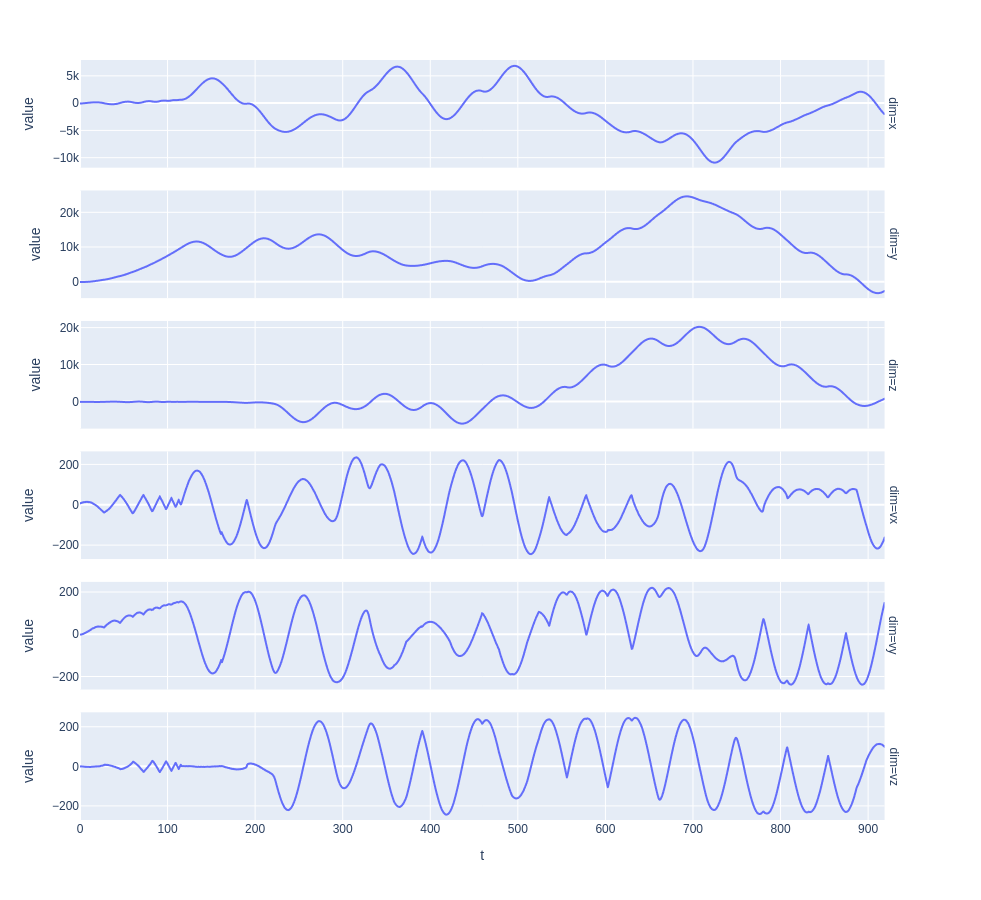

In [178]:
fig = ex.line(df.melt(['t'], ['x', 'y', 'z', 'vx', 'vy', 'vz'], 'dim', 'value'), x='t', y='value', facet_row='dim')
fig.update_yaxes(matches=None)
fig.update_layout(height=900)
fig

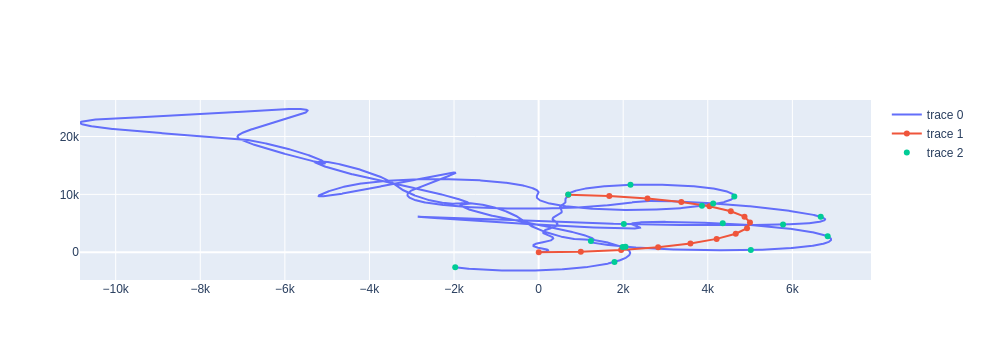

In [179]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=trace[:,1], y=trace[:,2]))

wp = np.asarray(waypoints)
fig.add_trace(go.Scatter(x=wp[:,0], y=wp[:,1]))

adv = np.asarray(adv)
fig.add_trace(go.Scatter(x=adv[:,1], y=adv[:,2], mode='markers'))

fig

In [145]:
adv

array([[ 1.13600000e+02,  7.01816956e+02,  9.95283722e+03,
         8.67705411e-03,  1.05858987e+01,  1.50311111e+02,
         5.83627995e-02],
       [ 1.13700000e+02,  7.04185722e+02,  9.96772086e+03,
         1.67985146e-02,  2.36876661e+01,  1.48836427e+02,
         8.12146052e-02],
       [ 1.13800000e+02,  7.07844281e+02,  9.98237121e+03,
         1.89598958e-02,  3.65855882e+01,  1.46503468e+02,
         2.16138114e-02],
       [ 1.13900000e+02,  7.12758117e+02,  9.99666481e+03,
        -6.62716164e-03,  4.91383579e+01,  1.42936012e+02,
        -2.55870574e-01],
       [ 1.14000000e+02,  7.18897908e+02,  1.00104776e+04,
        -3.78182993e-02,  6.13979091e+01,  1.38127553e+02,
        -3.11911376e-01],
       [ 1.14100000e+02,  7.26216430e+02,  1.00237071e+04,
        -7.67891524e-02,  7.31852194e+01,  1.32294893e+02,
        -3.89708531e-01],
       [ 1.14200000e+02,  7.34639550e+02,  1.00362525e+04,
        -1.17083110e-01,  8.42312016e+01,  1.25453963e+02,
        -4.0293957

In [66]:
waypoints[:10]

[(3.9816335536663168, 0.0015853408267503255, 0.0),
 (53.98058529133696, 0.29139885016866174, 0.0),
 (103.97413901546214, 1.0811790532152372, 0.0),
 (153.9572954123306, 2.3708469726043404, 0.0),
 (203.92505620795518, 4.160273642620268, 0.0),
 (253.8724246678959, 6.449280122084929, 0.0),
 (303.7944060969295, 9.237637512259425, 0.0),
 (353.6860083385145, 12.525066979727853, 0.0),
 (403.5422422740032, 16.311239784283316, 0.0),
 (453.3581223215484, 20.595777311799793, 0.0)]

In [ ]:
initial_pos = [0, 0, 0]  # Starting at origin
initial_vel = [10, 0, 0]  # Moving initially along x-axis

vehicle = AirVehicleMover(initial_pos, initial_vel, mass=1000, thrust_force=5000, drag_coefficient=0.05)
trace   = vehicle.simulate(t_max=20)
df      = to_df(trace, columns=['t', 'x', 'y', 'z', 'vx', 'vy', 'vz'])
df

In [ ]:
fig = ex.line(df.melt(['t'], ['x', 'y', 'z', 'vx', 'vy', 'vz'], 'dim', 'value'), x='t', y='value', facet_row='dim')
fig.update_yaxes(matches=None)
fig

# Cone + Line

Check intersection between a cone and a line in 3D or find a point on the cone closest to the line.

Cone is defined by its apex, direction axis and half-angle $(V, d, \theta)$. Line is defined by a direction vector $l = B - A$, where $A$ and $B$ are two arbitrary point which belong to that line. Equations below define them in 3D with point $r$ as the variable.

* cone: $(r - V) \cdot d = |r - V| \cdot \cos\theta$
* line: $r(t) = A + t \cdot (B - A) = A + t \cdot l$

Now, we substitute the line equation into the cone equation:

$(A + t \cdot l - V) \cdot d = |A + t \cdot l| \cos\theta$

and define $w = A - V$:

$(w + tl) \cdot d = |w + tl| \cos\theta$

Next, we raise both sides to the power of $2$ to eliminate vector norm $|\cdot|$:

$\left[(w + tl) \cdot d\right]^2 = (w + tl)(w + tl) \cos^2\theta$

which leads to:

$(wd + tld)^2 = (w^2 + 2tlw + t^2 l^2) \cos^2\theta$

and:

$w^2d^2 + 2wdldt + t^2l^2d^2 = (w^2 + 2tlw + t^2 l^2) \cos^2\theta$

and finally:

$t^2 (l^2d^2 - l^2\cos^2\theta) + t (2wdld - 2lw\cos^2\theta) + (wd)^2 - w^2\cos^2\theta = 0$

We now have a quadratic equation of $t$ with coefficients:

$a = (l{\cdot}d)^2 - l{\cdot}l\cos^2\theta$

$b = 2\left[(w{\cdot}d)(l{\cdot}d) - w{\cdot}l\cos^2\theta\right]$

$c = (w{\cdot}d)^2 - w{\cdot}w\cos^2\theta$

We proceed by solving this equation with $\Delta = b^2 - 4ac$.

In [ ]:
def normalize(vector):
    return vector / np.linalg.norm(vector)

def next_direction(V, d, theta, A, B):
    d = normalize(d)
    
    AB = B - A
    l = normalize(AB)

    w = A - V

    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
        
    # Coefficients for the quadratic equation at^2 + bt + c = 0
    a = (np.dot(v, d) ** 2) - np.dot(v, v) * (cos_theta ** 2)
    b = 2 * (np.dot(w, d) * np.dot(l, d) - np.dot(w, l) * (cos_theta ** 2))
    c = (np.dot(w, d) ** 2) - np.dot(w, w) * (cos_theta ** 2)
    
    # Solve quadratic equation
    discriminant = b ** 2 - 4 * a * c

    # No intersection. Find closest point on the cone surface: the minimum
    # of the parabola
    if discriminant < 0:
        assert (a != 0)
        t_opt = -b / 2*a
        return (A + t_opt * l) - V
    
    else:
        # Intersection exists, solve for t
        t1 = (-b + np.sqrt(discriminant)) / (2 * a)
        t2 = (-b - np.sqrt(discriminant)) / (2 * a)

        # since B is the next waypoint, pick larger t
        t_max = t1 if t1 > t2 else t2
        
        return (A + t_max * l) - V
        

# Example Usage
V = np.array([0, 0, 0])
d = np.array([0, 0, 1])
theta = np.radians(30)  # 30 degrees
A = np.array([1, 1, 1])
B = np.array([2, 2, 2])

result = check_intersection_and_find_closest_direction(V, d, theta, A, B)

if result is not None:
    print("Closest direction vector:", result)